<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/1%EB%B2%88_DataProcessing(Generating_Features_Bytime2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이콘 게임 행동 데이터 분석
출처 : https://newfront.dacon.io/competitions/official/235583/overview/

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
#from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시
%time
train = pd.read_csv('./train.csv')

#%time
#test = pd.read_pickle('./test.pkl')

변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


## 1. time 2씩 나눠 구간별로 event 카운팅함

In [0]:
def event_count_bytime(df = None, know_y = False):
    # 총 경기시간
    time_list = pd.DataFrame( df.groupby(['game_id']).time.max()  )
    time_list = time_list.rename(columns = {'time' : 'time_list'})
    # 종족
    species = pd.DataFrame(df.groupby(['player','game_id']).species.unique().unstack(0))
    species.columns = ['P0_species','P1_species']
    # 승자결과
    if know_y == True:
        winners = pd.DataFrame(df.groupby(['game_id']).winner.max())
    
    # 시간별 이벤트 카운팅
    #bytimes = [i for i in range(11)] ## 1분 간격
    bytimes = [i for i in [0,2,4,6,8,10]] ## 3분 간격

    events = ['Ability', 'AddToControlGroup', 'Camera', 'ControlGroup', 'GetControlGroup', 'Right Click', 'Selection', 'SetControlGroup']
    p0_columns = ['P0_'+str(event)+'_bytime_'+str(bytime) for event in events for bytime in bytimes]
    p1_columns = ['P1_'+str(event)+'_bytime_'+str(bytime) for event in events for bytime in bytimes]

    ## 빈 데이터프레임 생성
    newdata = np.zeros(len(df.game_id.unique())*len(p0_columns+p1_columns)).reshape(len(df.game_id.unique()),len(p0_columns+p1_columns))
    newdata = pd.DataFrame(newdata , columns =p0_columns+p1_columns)
    newdata.index = df.game_id.unique()

    for t in tqdm_notebook(bytimes):
        time_t = df.loc[(df.time >= t) & (df.time < t+2),:] # t분부터 t+1분 사이의 데이터
        #time_t = df.loc[(df.time < t+1),:] #t+1분 미만의 데이터
        for event_name in events:
            Value_Count0 = pd.DataFrame(time_t.groupby(['player','game_id']).event.value_counts()).unstack(level=-1).event[event_name].unstack(0).iloc[:,0] #player0
            Value_Count1 = pd.DataFrame(time_t.groupby(['player','game_id']).event.value_counts()).unstack(level=-1).event[event_name].unstack(0).iloc[:,1] #player0
            newdata.loc[:,'P0_'+str(event_name)+'_bytime_'+str(t)]=Value_Count0
            newdata.loc[:,'P1_'+str(event_name)+'_bytime_'+str(t)]=Value_Count1
    
    if know_y == True:
        newdata = pd.concat([newdata,time_list,species,winners],axis=1)
    else:
        newdata = pd.concat([newdata,time_list,species],axis=1)
    return newdata           

In [0]:
newtrain = event_count_bytime(df = train, know_y = True)
newtrain= newtrain.fillna(0)
#newtrain.info()

In [0]:
p0_columns_time0 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_0')]
p1_columns_time0 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_0')]
p0_columns_time2 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_2')]
p1_columns_time2 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_2')]
p0_columns_time4 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_4')]
p1_columns_time4 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_4')]
p0_columns_time6 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_6')]
p1_columns_time6 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_6')]
p0_columns_time8 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_8')]
p1_columns_time8 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_8')]
p0_columns_time10 = [c for c in newtrain.columns if c.startswith('P0_') and c.endswith('bytime_10')]
p1_columns_time10 = [c for c in newtrain.columns if c.startswith('P1_') and c.endswith('bytime_10')]

for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time0,  p0_columns_time2,  p1_columns_time0,  p1_columns_time2):
    newtrain[p0_feat3]=newtrain.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtrain[p1_feat3]=newtrain.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time2,  p0_columns_time4,  p1_columns_time2,  p1_columns_time4):
    newtrain[p0_feat3]=newtrain.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtrain[p1_feat3]=newtrain.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time4,  p0_columns_time6,  p1_columns_time4,  p1_columns_time6):
    newtrain[p0_feat3]=newtrain.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtrain[p1_feat3]=newtrain.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time6,  p0_columns_time8,  p1_columns_time6,  p1_columns_time8):
    newtrain[p0_feat3]=newtrain.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtrain[p1_feat3]=newtrain.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time8,  p0_columns_time10,  p1_columns_time8,  p1_columns_time10):
    newtrain[p0_feat3]=newtrain.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtrain[p1_feat3]=newtrain.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)

newtrain.describe()

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,P1_AddToControlGroup_bytime_8,P1_AddToControlGroup_bytime_10,P1_Camera_bytime_0,P1_Camera_bytime_2,P1_Camera_bytime_4,P1_Camera_bytime_6,P1_Camera_bytime_8,P1_Camera_bytime_10,P1_ControlGroup_bytime_0,P1_ControlGroup_bytime_2,P1_ControlGroup_bytime_4,P1_ControlGroup_bytime_6,P1_ControlGroup_bytime_8,P1_ControlGroup_bytime_10,P1_GetControlGroup_bytime_0,P1_GetControlGroup_bytime_2,P1_GetControlGroup_bytime_4,P1_GetControlGroup_bytime_6,P1_GetControlGroup_bytime_8,P1_GetControlGroup_bytime_10,P1_Right Click_bytime_0,P1_Right Click_bytime_2,P1_Right Click_bytime_4,P1_Right Click_bytime_6,P1_Right Click_bytime_8,P1_Right Click_bytime_10,P1_Selection_bytime_0,P1_Selection_bytime_2,P1_Selection_bytime_4,P1_Selection_bytime_6,P1_Selection_bytime_8,P1_Selection_bytime_10,P1_SetControlGroup_bytime_0,P1_SetControlGroup_bytime_2,P1_SetControlGroup_bytime_4,P1_SetControlGroup_bytime_6,P1_SetControlGroup_bytime_8,P1_SetControlGroup_bytime_10,time_list,winner
count,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,...,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,7.431467,18.142236,30.575427,41.003627,48.476178,48.806467,0.457502,0.881251,1.297361,1.643934,1.904996,1.918450,79.440214,179.542781,273.952794,349.860774,404.903530,407.357918,0.116948,0.203437,0.286324,0.351358,0.393908,0.396275,43.751595,80.108690,103.278787,119.119855,129.067735,129.523307,29.220416,64.809066,99.850587,128.037868,148.046975,148.942118,31.815265,59.001441,84.699681,106.646404,...,1.910012,1.923390,79.370935,179.402989,273.384441,348.990662,403.883644,406.323060,0.118697,0.199218,0.278658,0.346599,0.392159,0.393985,43.650983,79.897921,102.925731,118.719258,128.623019,129.047901,29.021198,64.568687,99.688362,127.824835,147.706704,148.595364,31.677274,58.695231,84.233124,106.036659,121.460486,122.131560,1.915157,2.730166,3.432162,4.005454,4.382023,4.399156,7.289366,0.501621
std,2.544722,6.314469,13.162384,20.721461,27.707051,28.119083,0.937607,1.435750,2.003790,2.540955,3.009919,3.038626,46.618459,86.199005,128.840126,175.399127,219.762645,222.351156,1.206608,1.912490,2.499977,

In [0]:
newtrain.to_pickle('train16.pkl')
newtrain.head(2)

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,P1_Camera_bytime_0,P1_Camera_bytime_2,P1_Camera_bytime_4,P1_Camera_bytime_6,P1_Camera_bytime_8,P1_Camera_bytime_10,P1_ControlGroup_bytime_0,P1_ControlGroup_bytime_2,P1_ControlGroup_bytime_4,P1_ControlGroup_bytime_6,P1_ControlGroup_bytime_8,P1_ControlGroup_bytime_10,P1_GetControlGroup_bytime_0,P1_GetControlGroup_bytime_2,P1_GetControlGroup_bytime_4,P1_GetControlGroup_bytime_6,P1_GetControlGroup_bytime_8,P1_GetControlGroup_bytime_10,P1_Right Click_bytime_0,P1_Right Click_bytime_2,P1_Right Click_bytime_4,P1_Right Click_bytime_6,P1_Right Click_bytime_8,P1_Right Click_bytime_10,P1_Selection_bytime_0,P1_Selection_bytime_2,P1_Selection_bytime_4,P1_Selection_bytime_6,P1_Selection_bytime_8,P1_Selection_bytime_10,P1_SetControlGroup_bytime_0,P1_SetControlGroup_bytime_2,P1_SetControlGroup_bytime_4,P1_SetControlGroup_bytime_6,P1_SetControlGroup_bytime_8,P1_SetControlGroup_bytime_10,time_list,P0_species,P1_species,winner
0,8.0,18.0,26.0,34.0,34.0,34.0,0.0,1.0,2.0,2.0,2.0,2.0,82.0,228.0,349.0,444.0,444.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,19.0,24.0,24.0,24.0,9.0,14.0,26.0,35.0,35.0,35.0,11.0,21.0,35.0,50.0,...,52.0,206.0,372.0,425.0,425.0,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,5.0,25.0,28.0,28.0,28.0,4.0,22.0,42.0,57.0,57.0,57.0,1.0,1.0,1.0,1.0,1.0,1.0,7.24,[T],[T],1
1,9.0,23.0,40.0,59.0,77.0,77.0,0.0,1.0,1.0,1.0,1.0,1.0,59.0,190.0,325.0,461.0,627.0,627.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,132.0,144.0,152.0,162.0,162.0,18.0,56.0,84.0,108.0,160.0,160.0,78.0,101.0,126.0,154.0,...,134.0,287.0,487.0,666.0,858.0,858.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,11.0,19.0,26.0,31.0,31.0,8.0,50.0,67.0,98.0,131.0,131.0,11.0,33.0,57.0,91.0,116.0,116.0,4.0,4.0,5.0,8.0,8.0,8.0,9.59,[P],[T],1


In [0]:

test = pd.read_csv('test.csv')
newtest = event_count_bytime(df = test, know_y = False)
newtest= newtest.fillna(0)
#newtest.tail()

In [0]:
p0_columns_time0 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_0')]
p1_columns_time0 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_0')]
p0_columns_time2 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_2')]
p1_columns_time2 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_2')]
p0_columns_time4 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_4')]
p1_columns_time4 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_4')]
p0_columns_time6 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_6')]
p1_columns_time6 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_6')]
p0_columns_time8 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_8')]
p1_columns_time8 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_8')]
p0_columns_time10 = [c for c in newtest.columns if c.startswith('P0_') and c.endswith('bytime_10')]
p1_columns_time10 = [c for c in newtest.columns if c.startswith('P1_') and c.endswith('bytime_10')]

In [0]:
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time0,  p0_columns_time2,  p1_columns_time0,  p1_columns_time2):
    newtest[p0_feat3]=newtest.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtest[p1_feat3]=newtest.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time2,  p0_columns_time4,  p1_columns_time2,  p1_columns_time4):
    newtest[p0_feat3]=newtest.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtest[p1_feat3]=newtest.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time4,  p0_columns_time6,  p1_columns_time4,  p1_columns_time6):
    newtest[p0_feat3]=newtest.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtest[p1_feat3]=newtest.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time6,  p0_columns_time8,  p1_columns_time6,  p1_columns_time8):
    newtest[p0_feat3]=newtest.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtest[p1_feat3]=newtest.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time8,  p0_columns_time10,  p1_columns_time8,  p1_columns_time10):
    newtest[p0_feat3]=newtest.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    newtest[p1_feat3]=newtest.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
newtest.describe()

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,P1_AddToControlGroup_bytime_6,P1_AddToControlGroup_bytime_8,P1_AddToControlGroup_bytime_10,P1_Camera_bytime_0,P1_Camera_bytime_2,P1_Camera_bytime_4,P1_Camera_bytime_6,P1_Camera_bytime_8,P1_Camera_bytime_10,P1_ControlGroup_bytime_0,P1_ControlGroup_bytime_2,P1_ControlGroup_bytime_4,P1_ControlGroup_bytime_6,P1_ControlGroup_bytime_8,P1_ControlGroup_bytime_10,P1_GetControlGroup_bytime_0,P1_GetControlGroup_bytime_2,P1_GetControlGroup_bytime_4,P1_GetControlGroup_bytime_6,P1_GetControlGroup_bytime_8,P1_GetControlGroup_bytime_10,P1_Right Click_bytime_0,P1_Right Click_bytime_2,P1_Right Click_bytime_4,P1_Right Click_bytime_6,P1_Right Click_bytime_8,P1_Right Click_bytime_10,P1_Selection_bytime_0,P1_Selection_bytime_2,P1_Selection_bytime_4,P1_Selection_bytime_6,P1_Selection_bytime_8,P1_Selection_bytime_10,P1_SetControlGroup_bytime_0,P1_SetControlGroup_bytime_2,P1_SetControlGroup_bytime_4,P1_SetControlGroup_bytime_6,P1_SetControlGroup_bytime_8,P1_SetControlGroup_bytime_10,time_list
count,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,...,16787.000000,16787.000000,16787.00000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.00000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000
mean,7.397093,18.054506,30.386251,40.770001,48.218443,48.555370,0.455769,0.871806,1.268482,1.616787,1.875499,1.890808,78.856794,177.903854,271.117114,346.411688,401.124561,403.682909,0.106630,0.189968,0.256806,0.317925,0.354143,0.355573,43.645083,79.851671,103.034551,118.883839,128.676655,129.127539,28.681897,63.964913,98.407994,125.920653,145.428248,146.354560,31.637517,58.551736,83.817418,105.423065,...,1.615774,1.877226,1.89063,78.885328,177.588551,271.178591,346.748138,401.424555,403.957884,0.111694,0.188896,0.261095,0.325609,0.365283,0.368082,42.477274,78.128314,100.884851,116.601537,126.307857,126.730863,29.069459,64.398463,99.063382,126.801811,146.352237,147.323286,31.533389,58.49032,83.737178,105.329302,120.696313,121.432835,1.920951,2.735212,3.438315,4.001311,4.382201,4.401203,7.263197
std,2.508546,6.371016,13.239429,20.869773,27.932083,28.336043,0.950581,1.444310,1.980799,2.506156,2.973309,3.006079,46.622121,86.519787,129.884928,177.331645,221.733792,224.468756,1.115383

In [0]:
newtest.to_pickle('test16.pkl')
print(newtest.shape)
print(newtest.shape)

(16787, 99)
(16787, 99)


## 2. map 변수를 추가

In [0]:
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [0]:
df_train = pd.DataFrame(train.game_id.unique(), columns=['game_id'])
df_train.index = df_train.game_id
df_train = df_train.drop(['game_id'], axis = 1)


# 처음 기록 된 카메라 좌표를 기록

df_train_p0 = train[(train.event=='Camera')&(train.player==0)]
# shift(1)를 이용하면 데이터가 한칸씩 아래로 내려감 => 게임아이디 비교를 통해 Boolean을 반환하면, 각 게임의 첫 행을 찾을 수 있음
df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_train_p0 = df_train_p0.loc[:, ['game_id','event_contents']].rename({'event_contents':'player0_starting'}, axis = 1)
df_train_p0.index = df_train_p0['game_id']
df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p0, on='game_id', how='left')
del df_train_p0

df_train_p1 = train[(train.event=='Camera')&(train.player==1)]
df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
df_train_p1 = df_train_p1.loc[:, ['game_id','event_contents']].rename({'event_contents':'player1_starting'}, axis = 1)
df_train_p1.index = df_train_p1['game_id']
df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p1, on='game_id', how='left')
del df_train_p1



df_test = pd.DataFrame(test.game_id.unique(), columns=['game_id'])
df_test.index = df_test.game_id
df_test = df_test.drop(['game_id'], axis = 1)


# 처음 기록 된 카메라 좌표를 기록

df_test_p0 = test[(test.event=='Camera')&(test.player==0)]
# shift(1)를 이용하면 데이터가 한칸씩 아래로 내려감 => 게임아이디 비교를 통해 Boolean을 반환하면, 각 게임의 첫 행을 찾을 수 있음
df_test_p0 = df_test_p0[df_test_p0.shift(1).game_id!=df_test_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_test_p0 = df_test_p0.loc[:, ['game_id','event_contents']].rename({'event_contents':'player0_starting'}, axis = 1)
df_test_p0.index = df_test_p0['game_id']
df_test_p0 = df_test_p0.drop(['game_id'], axis=1)
df_test = pd.merge(df_test, df_test_p0, on='game_id', how='left')
del df_test_p0

df_test_p1 = test[(test.event=='Camera')&(test.player==1)]
df_test_p1 = df_test_p1[df_test_p1.shift(1).game_id!=df_test_p1.game_id]
df_test_p1 = df_test_p1.loc[:, ['game_id','event_contents']].rename({'event_contents':'player1_starting'}, axis = 1)
df_test_p1.index = df_test_p1['game_id']
df_test_p1 = df_test_p1.drop(['game_id'], axis=1)
df_test = pd.merge(df_test, df_test_p1, on='game_id', how='left')
del df_test_p1



####################################################################################################
# x, y 값으로 분리

df_train['player0_starting'] = df_train.player0_starting.str.split('(').str[1]
df_train['player0_starting'] = df_train.player0_starting.str.split(')').str[0]
split_xy = df_train.player0_starting.str.split(',')
df_train['player0_x'] = split_xy.str[0].astype('float')
df_train['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_train['player1_starting'] = df_train.player1_starting.str.split('(').str[1]
df_train['player1_starting'] = df_train.player1_starting.str.split(')').str[0]
split_xy = df_train.player1_starting.str.split(',')
df_train['player1_x'] = split_xy.str[0].astype('float')
df_train['player1_y'] = split_xy.str[1].astype('float')
del split_xy

# x, y 값으로 분리

df_test['player0_starting'] = df_test.player0_starting.str.split('(').str[1]
df_test['player0_starting'] = df_test.player0_starting.str.split(')').str[0]
split_xy = df_test.player0_starting.str.split(',')
df_test['player0_x'] = split_xy.str[0].astype('float')
df_test['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_test['player1_starting'] = df_test.player1_starting.str.split('(').str[1]
df_test['player1_starting'] = df_test.player1_starting.str.split(')').str[0]
split_xy = df_test.player1_starting.str.split(',')
df_test['player1_x'] = split_xy.str[0].astype('float')
df_test['player1_y'] = split_xy.str[1].astype('float')
del split_xy

####################################################################################################
# 플레이어의 x,y 좌표를 한곳으로(location) 모음

location_train_p0 = df_train.loc[:, ['player0_x', 'player0_y']]
location_train_p0 = location_train_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_train_p1 = df_train.loc[:, ['player1_x', 'player1_y']]
location_train_p1 = location_train_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_train_p1.index += location_train_p0.index[-1]+1

location_train = pd.concat([location_train_p0, location_train_p1])
location_train = location_train.dropna()
del location_train_p0, location_train_p1
location_train.head()
print(location_train.shape)

# 플레이어의 x,y 좌표를 한곳으로(location) 모음

location_test_p0 = df_test.loc[:, ['player0_x', 'player0_y']]
location_test_p0 = location_test_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_test_p1 = df_test.loc[:, ['player1_x', 'player1_y']]
location_test_p1 = location_test_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_test_p1.index += location_test_p0.index[-1]+1

location_test = pd.concat([location_test_p0, location_test_p1])
location_test = location_test.dropna()
del location_test_p0, location_test_p1
location_test.head()
print(location_test.shape)

(77722, 2)
(33563, 2)


In [0]:
location_train['key']='train'
location_test['key']='test'
location = pd.concat([location_train,location_test],axis=0)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# kmeans를 이용하여 15개로 클러스터링
kmeans_clst = KMeans(n_clusters=15, random_state=4321).fit(location[['location_x','location_y']])
location['starting'] = kmeans_clst.labels_+1

location_train = location.loc[location.key == 'train',:]
location_test = location.loc[location.key == 'test',:]



### Train Set

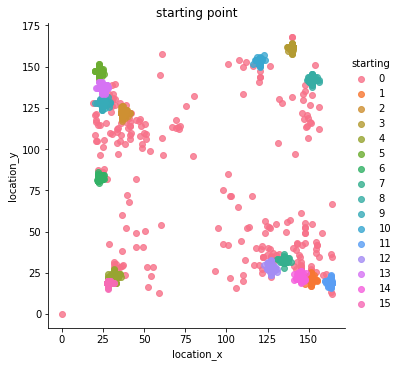

[[  1.   9. 999.]
 [  2.  11. 999.]
 [  3.  15. 999.]
 [  4.   8. 999.]
 [  5.  14. 999.]
 [  6.   7.  10.]
 [ 12.  13. 999.]]


In [0]:
# kmeans로 찾은 15개의 포인트에서 각 데이터들의 거리 계산
for cluster in range(15):
    point = location_train[location_train.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location_train.loc[loc.index, 'distance'] = distance
    location_train.loc[loc.index, 'center_x'] = loc.center_x
    location_train.loc[loc.index, 'center_y'] = loc.center_y
    del loc
#print(location_train.tail())

# 일정 거리(5)이상 떨어진 데이터는 starting을 0으로 지정
idx = location_train[location_train.distance>5].index
location_train.loc[idx, 'starting'] = 0
del idx
# 시각화를 통해 스타팅을 모르는 게임은 분홍색(0)으로 나타며 15개의 스타팅 포인트를 확인 할 수 있음.
sns.lmplot('location_x', 'location_y', data = location_train, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

###############################################################################
# 클러스터링한 결과 반영
df_train['player0_starting'] = location_train.loc[df_train.index, 'starting']
df_train['player0_center_x'] = location_train.loc[df_train.index, 'center_x']
df_train['player0_center_y'] = location_train.loc[df_train.index, 'center_y']
location_train.index -= (df_train.index[-1]+1)
df_train['player1_starting'] = location_train.loc[df_train.index, 'starting']
df_train['player1_center_x'] = location_train.loc[df_train.index, 'center_x']
df_train['player1_center_y'] = location_train.loc[df_train.index, 'center_y']
del location_train

# 불필요한 컬럼 삭제
df_train = df_train.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_train = df_train.fillna(0)
#df_train.head()

###############################################################################
# 스타팅 포인트를 이용하여 맵 분류
map_list = []
for point in range(1,16):
    couple = df_train[df_train.player0_starting == point].player1_starting.value_counts()
    if len(couple)<2 or couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)
# 6개의 2인용 맵과 1개의 3인용 맵이 존재

# TMI: 스타크래프트2 공허의유산 래더에서 3인용 맵이 쓰인적은 '까탈레나' 딱 한 번.
# 이를 통해 2017년 7월20일 ~ 2017년 11월16일 사이에 진행 된 게임 정보라는 것을 알 수 있음.
# 나머지 6개의 맵은 '어비설리프', '어센션투아이어', '애컬라이트', '인터로퍼', '오딧세이', '메크디포'
# 근데 결과 예측하는데 맵 이름 상관 없음
print(map_list)
#print('-'*50)
# 스타팅을 모르는 게임 수 확인.
#print(len(df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)]))

In [0]:
# map_list와 상대편 위치 정보를 이용하여 모르는 스타팅 찾기
for m in map_list:
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[0])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[1])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[0])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[1])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[0]
    del idx
# 더이상 스타팅 모르는 게임 없음
df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)].head()

,player0_starting,player1_starting,player0_center_x,player0_center_y,player1_center_x,player1_center_y
game_id,,,,,,


In [0]:
# 맵 컬럼 추가
for map_num, m in enumerate(map_list):
    idx = df_train[(df_train.player0_starting == m[0])|(df_train.player0_starting == m[1])|(df_train.player0_starting == m[2])].index
    df_train.loc[idx, 'map'] = map_num
del idx, map_list
# 스타팅포인트, 맵 클러스터링 끝
#df_train.head()

In [0]:
train16 = pd.read_pickle('train16.pkl')
train16['player0_starting_category'] = df_train['player0_starting']
train16['player1_starting_category'] = df_train['player1_starting']
train16['map'] = df_train['map']
train16['player0_center_x'] = df_train['player0_center_x']
train16['player0_center_y'] = df_train['player0_center_y']
train16['player1_center_x'] = df_train['player1_center_x']
train16['player1_center_y'] = df_train['player1_center_y']
train16.to_pickle('train16.pkl')
train16.shape

(38872, 107)

### Test Set

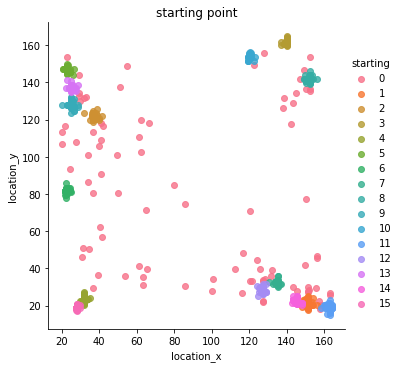

[[  1.   9. 999.]
 [  2.  11. 999.]
 [  3.  15. 999.]
 [  4.   8. 999.]
 [  5.  14. 999.]
 [  6.   7.  10.]
 [ 12.  13. 999.]]


In [0]:
# kmeans로 찾은 15개의 포인트에서 각 데이터들의 거리 계산
for cluster in range(15):
    point = location_test[location_test.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location_test.loc[loc.index, 'distance'] = distance
    location_test.loc[loc.index, 'center_x'] = loc.center_x
    location_test.loc[loc.index, 'center_y'] = loc.center_y
    del loc
#print(location_test.tail())

# 일정 거리(5)이상 떨어진 데이터는 starting을 0으로 지정
idx = location_test[location_test.distance>5].index
location_test.loc[idx, 'starting'] = 0
del idx
# 시각화를 통해 스타팅을 모르는 게임은 분홍색(0)으로 나타며 15개의 스타팅 포인트를 확인 할 수 있음.
sns.lmplot('location_x', 'location_y', data = location_test, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()


# 클러스터링한 결과 반영
df_test['player0_starting'] = location_test.loc[df_test.index, 'starting']
df_test['player0_center_x'] = location_test.loc[df_test.index, 'center_x']
df_test['player0_center_y'] = location_test.loc[df_test.index, 'center_y']
location_test.index -= (df_test.index[-1]+1)
df_test['player1_starting'] = location_test.loc[df_test.index, 'starting']
df_test['player1_center_x'] = location_test.loc[df_test.index, 'center_x']
df_test['player1_center_y'] = location_test.loc[df_test.index, 'center_y']
del location_test

# 불필요한 컬럼 삭제
df_test = df_test.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_test = df_test.fillna(0)
#print(df_test.head())
#print(df_test.tail())

# 스타팅 포인트를 이용하여 맵 분류
map_list = []
for point in range(1,16):
    couple = df_test[df_test.player0_starting == point].player1_starting.value_counts()
    if len(couple)<2 or couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)
# 6개의 2인용 맵과 1개의 3인용 맵이 존재

# TMI: 스타크래프트2 공허의유산 래더에서 3인용 맵이 쓰인적은 '까탈레나' 딱 한 번.
# 이를 통해 2017년 7월20일 ~ 2017년 11월16일 사이에 진행 된 게임 정보라는 것을 알 수 있음.
# 나머지 6개의 맵은 '어비설리프', '어센션투아이어', '애컬라이트', '인터로퍼', '오딧세이', '메크디포'
# 근데 결과 예측하는데 맵 이름 상관 없음
print(map_list)

# 스타팅을 모르는 게임 수 확인.
#print(len(df_test[(df_test.player0_starting == 0)|(df_test.player1_starting == 0)]))

In [0]:
# map_list와 상대편 위치 정보를 이용하여 모르는 스타팅 찾기
for m in map_list:
    idx = df_test[(df_test.player0_starting == 0)&((df_test.player1_starting == m[0])|(df_test.player1_starting == m[2]))].index
    df_test.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_test[(df_test.player0_starting == 0)&((df_test.player1_starting == m[1])|(df_test.player1_starting == m[2]))].index
    df_test.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_test[(df_test.player1_starting == 0)&((df_test.player0_starting == m[0])|(df_test.player0_starting == m[2]))].index
    df_test.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_test[(df_test.player1_starting == 0)&((df_test.player0_starting == m[1])|(df_test.player0_starting == m[2]))].index
    df_test.loc[idx, 'player1_starting'] = m[0]
    del idx
# 더이상 스타팅 모르는 게임 없음
df_test[(df_test.player0_starting == 0)|(df_test.player1_starting == 0)].head()

,player0_starting,player1_starting,player0_center_x,player0_center_y,player1_center_x,player1_center_y
game_id,,,,,,


In [0]:
# 맵 컬럼 추가
for map_num, m in enumerate(map_list):
    idx = df_test[(df_test.player0_starting == m[0])|(df_test.player0_starting == m[1])|(df_test.player0_starting == m[2])].index
    df_test.loc[idx, 'map'] = map_num
del idx, map_list
# 스타팅포인트, 맵 클러스터링 끝
#df_test.head()

test16 = pd.read_pickle('test16.pkl')
test16['player0_starting_category'] = df_test['player0_starting']
test16['player1_starting_category'] = df_test['player1_starting']
test16['map'] = df_test['map']
test16['player0_center_x'] = df_test['player0_center_x']
test16['player0_center_y'] = df_test['player0_center_y']
test16['player1_center_x'] = df_test['player1_center_x']
test16['player1_center_y'] = df_test['player1_center_y']

In [0]:
test16.to_pickle('test16.pkl')

In [0]:
print(train16.shape)
print(test16.shape)

(38872, 107)
(16787, 106)


## 3. event_contents 변수들

In [0]:
#train = pd.read_csv('train.csv')
train16 = pd.read_pickle('train16.pkl')

In [0]:
def eventcontents_bytime(df = None):

    # 시간별 이벤트 카운팅
    bytimes = [t for t in [0,2,4,6,8,10] ] ## 1분 간격

    event_contents_Ability = ['Worker_num','Up_Attack','Up_Armor','Population','Multi_num','Gas_num','Attack_Worker','Attack_Multi','Attack_All','Attack_Tar','Up_etc',
                                'Prod_Mp','Build_Tower','Prod_Mp_weight','Patrol']+['Pylon','Nexus','Command','Overseer','Hatchery']+['Zergling','Roach','Adept','Queen',
                                'Stalker','Mutalisk','Viking','Phoenix','SiegeTank','Oracle','Immortal','VoidRay','Tempest','Ultralisk',
                                'Carrier','Battlecruiser'] # Column 이름 생성을 위한 리스트
    
    event_contents_Selection = ['Select_Prod_Structure','Select_Empty','Select_Worker']
    event_contents_Right_Click = ['Click_Resources','Click_DSC','Click_DSG','Click_DSF','Click_COB','Click_Gas','Click_Multi']    #DestructibleCreepOnlyBlocker


    #  일꾼공격횟수, 멀티공격횟수, 어택땅횟수, 일점사횟수, 공방업말고 각종 업글횟수, 일꾼말고병력생산개수, 방어건물갯수,  병력최대선택개수,

    p0_columns = ['P0_'+str(event)+'_bytime_'+str(bytime) for event in event_contents_Ability + event_contents_Selection +event_contents_Right_Click for bytime in bytimes]
    p1_columns = ['P1_'+str(event)+'_bytime_'+str(bytime) for event in event_contents_Ability + event_contents_Selection +event_contents_Right_Click for bytime in bytimes]

    ## 빈 데이터프레임 생성
    newdata = np.zeros(len(df.game_id.unique())*len(p0_columns+p1_columns)).reshape(len(df.game_id.unique()),len(p0_columns+p1_columns))
    newdata = pd.DataFrame(newdata , columns =p0_columns+p1_columns)
    newdata.index = df.game_id.unique()

    for t in tqdm_notebook(bytimes):
        ################################################################ 1. Ability #########################################################################
        ### Ability가 가지는 event_contents 유니크 값들(검색을 위한 리스트) ###
        #all_eventcontents_list = time_t.groupby(['player','game_id']).event_contents.value_counts().unstack(level=0).index.get_level_values(1).unique().tolist()

        time_t = df.loc[(df.time >= t) & (df.time < t+2),:].loc[df.event=='Ability'] # t분부터 t+1분 사이의 데이터 # Ability 부분만

        ### Ability가 가지는 event_contents 유니크 값들(검색을 위한 리스트) ###
        all_eventcontents_list = time_t.loc[time_t['event']=='Ability'].event_contents.unique().tolist()

        time_t = pd.DataFrame(time_t.groupby(['player','game_id']).event_contents.value_counts())


        ############################### 1-0. 일꾼생산 ####################################
        matching_worker = [s for s in all_eventcontents_list if "TrainSCV" in s or 
                                                "TrainProbe" in s or 
                                                "MorphDrone" in s ]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching_worker].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching_worker].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[0]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[0]   )+'_bytime_'+str(t)]=Value_Count1
        newdata = newdata.fillna(0)

        ############################### 1-1. 지상&공중 공업 ####################################
        matching_up_at = [s for s in all_eventcontents_list if "UpgradeGroundWeapon" in s or "ResearchZergMissileWeaponsLevel" in s or "ResearchZergMeleeWeaponsLevel" in s or 
                                                "UpgradeTerranInfantryWeapon" in s or "UpgradeAirWeapon" in s or "UpgradeShipWeapon" in s or "EvolveFlyerAttack" in s or 
                                                "UpgradeVehicleWeapon" in s ]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching_up_at].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching_up_at].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[1]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[1]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-2. 지상&공중 방업 ####################################
        matching_up_ar = [s for s in all_eventcontents_list if "UpgradeGroundArmor" in s or "UpgradeTerranInfantryArmor" in s or "ResearchZergGroundArmorsLevel" in s or 
                                                "UpgradeShield" in s or "UpgradeAirArmor" in s or "ResearchTerranVehicleAndShipArmorsLevel" in s or
                                                "EvolveFlyerCarapace" in s ]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching_up_ar].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching_up_ar].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[2]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[2]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-3. 인구수 ####################################
        ############ 1)파일런&서플&오버로드 ############
        matching = [s for s in all_eventcontents_list if "BuildPylon" in s or "BuildSupplyDepot" in s or "MorphOverlord" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8, axis=1)
        ## 파일런, 서플, 오버로드 카운팅 데이터프레임에 대입(계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Pylon_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Pylon_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 2)넥서스 ############
        matching = [s for s in all_eventcontents_list if "BuildNexus" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*9, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*9, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Nexus_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Nexus_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 3)커맨드 ############
        matching = [s for s in all_eventcontents_list if "BuildCommandCenter" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*11, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*11, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Command_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Command_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 4)감시군주 ############
        matching = [s for s in all_eventcontents_list if "MorphToOverseer" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Overseer_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Overseer_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 5)해처리 ############
        matching = [s for s in all_eventcontents_list if "BuildHatchery" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Hatchery_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Hatchery_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ## apply 이용해서 실제 인구수 계산 후 인구수 변수 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[3]   )+'_bytime_'+str(t)] = newdata.apply(lambda x: x['P0_Pylon_bytime_'+str(t)] + x['P0_Nexus_bytime_'+str(t)] +
                                                                                            x['P0_Command_bytime_'+str(t)] + x['P0_Overseer_bytime_'+str(t)] + 
                                                                                            x['P0_Hatchery_bytime_'+str(t)], axis=1)
        newdata.loc[:,'P1_'+str(event_contents_Ability[3]   )+'_bytime_'+str(t)] = newdata.apply(lambda x: x['P1_Pylon_bytime_'+str(t)] + x['P1_Nexus_bytime_'+str(t)] + 
                                                                                            x['P1_Command_bytime_'+str(t)] + x['P1_Overseer_bytime_'+str(t)] + 
                                                                                            x['P1_Hatchery_bytime_'+str(t)], axis=1)
        # drop으로 필요없는 변수 제거
        newdata = newdata.drop(['P0_Pylon_bytime_'+str(t), 'P0_Nexus_bytime_'+str(t), 'P0_Command_bytime_'+str(t), 'P0_Overseer_bytime_'+str(t), 'P0_Hatchery_bytime_'+str(t),
                                'P1_Pylon_bytime_'+str(t), 'P1_Nexus_bytime_'+str(t), 'P1_Command_bytime_'+str(t), 'P1_Overseer_bytime_'+str(t), 'P1_Hatchery_bytime_'+str(t)],
                                axis=1)

        ############################### 1-4. 멀티수 ####################################
        matching = [s for s in all_eventcontents_list if "BuildNexus;" in s or "BuildCommandCenter;" in s or "BuildHatchery;" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[4]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[4]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-5. 가스수 ####################################
        matching = [s for s in all_eventcontents_list if "BuildRefinery;" in s or "BuildAssimilator;" in s or "BuildExtractor;" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[5]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[5]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-6. 일꾼공격횟수 ####################################
        matching = [s for s in all_eventcontents_list if "Attack; Target: Probe" in s or "Attack; Target: Drone" in s or 
                                                        "Attack; Target: SCV" in s  or "Attack; Target: MULE" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[6]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[6]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-7. 멀티공격횟수 ####################################
        matching = [s for s in all_eventcontents_list if "Attack; Target: Nexus" in s or "Attack; Target: CommandCenter" in s or 
                                                        "Attack; Target: PlanetaryFortress" in s  or "Attack; Target: OrbitalCommand" in s or
                                                        "Attack; Target: Hatchery" in s  or "Attack; Target: Lair" in s or "Attack; Target: Hive" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[7]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[7]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-8. 총 공격횟수 ####################################
        matching = [s for s in all_eventcontents_list if "Attack;" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[8]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[8]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-9. 일점사횟수 ####################################
        matching = [s for s in all_eventcontents_list if "Attack; Target:" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[9]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[9]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-10. 공방업말고 각종 업글횟수 ####################################
        matching = list(    set([s for s in all_eventcontents_list if "Upgrade" in s or "Research" in s or 
                                                                    "Evolve" in s]) - set(matching_up_at) - set(matching_up_ar)  )
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[10]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[10]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-11. 일꾼말고병력생산개수 ####################################
        matching = list(    set([s for s in all_eventcontents_list if "Morph" in s or "Train" in s or "BuildHellion" in s or "BuildSiegeTank" in s or 
                                                                    "BuildThor" in s or "Upgrade" in s or "BuildThor" in s or 'UpgradeToMothership' in s or 
                                                                    "WarpIn" in s or 'SpawnChangeling' in s]) - set(matching_worker) - set(['MorphOverlord']) )
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[11]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[11]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-12. 방어건물갯수 ####################################
        matching = [s for s in all_eventcontents_list if "BuildSpineCrawler;" in s or "BuildMissileTurret" in s or "BuildSporeCrawler" in s or 
                                                        "Bunker" in s or "BuildPhotonCannon" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[12]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[12]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ############################### 1-13. 많이 등장하는 병력들의 생산수 ####################################
        ############ 1)저글링&맹독충&마린 ############
        matching = [s for s in all_eventcontents_list if "MorphZergling" in s or "TrainBaneling" in s or "TrainMarine" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Zergling_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Zergling_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 2)바퀴, 궤멸충, 사신, 질럿, 화염차, 마인 ############
        matching = [s for s in all_eventcontents_list if "MorphRoach" in s or "MorphToRavager" in s or "TrainZealot" in s or "WarpInZealot" in s or
                    "BuildHellion" in s or "BuildWidowMine" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Roach_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Roach_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 2.5)사도, 불곰 ############
        matching = [s for s in all_eventcontents_list if "TrainAdept" in s or "WarpInAdept" in s or "TrainMarauder" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2.5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*2.5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Adept_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Adept_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 3)퀸, 히드라, 파수기, 러커 ############
        matching = [s for s in all_eventcontents_list if "TrainQueen" in s or "MorphHydralisk" in s or "TrainSentry" in s or "WarpInSentry" in s or 'MorphToLurker' in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*3, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*3, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Queen_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Queen_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 3.5)추적자, 군단숙주 ############
        matching = [s for s in all_eventcontents_list if "TrainStalker" in s or "WarpInStalker" in s or 'MorphSwarmHost' in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*3.5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*3.5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Stalker_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Stalker_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 4)뮤탈, 의료선,모선핵, 하템 ############
        matching = [s for s in all_eventcontents_list if "MorphMutalisk" in s or "TrainMedivac" in s or "TrainMothershipCore" in s or
                    "TrainHighTemplar" in s or "WarpInHighTemplar" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*4, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*4, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Mutalisk_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Mutalisk_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 4.5)바이킹 ############
        matching = [s for s in all_eventcontents_list if "TrainViking" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*4.5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*4.5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Viking_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Viking_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 5)차원분광기, 불사조, 타락귀, 감염자, 사이클론, 벤시, 분열기, 닥템 ############
        matching = [s for s in all_eventcontents_list if "TrainWarpPrism" in s or "TrainPhoenix" in s or 'MorphCorruptor' in s or 'MorphInfestor' in s or
                    "TrainCyclone" in s or "TrainBanshee" in s or "TrainDisruptor" in s or "WarpInDisruptor" in s or "TrainDarkTemplar" in s or "WarpInDarkTemplar" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Phoenix_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Phoenix_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 5.5)탱크 ############
        matching = [s for s in all_eventcontents_list if "BuildSiegeTank" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*5.5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*5.5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_SiegeTank_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_SiegeTank_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 6)예언자, 무리군주, 해방선, 밤까마귀  ############
        matching = [s for s in all_eventcontents_list if "TrainOracle" in s or "WarpInOracle" in s or 'MorphToBroodLord' in s or "TrainLiberator" in s or
                    "TrainRaven" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*6, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*6, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Oracle_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Oracle_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 7)불멸자 ############
        matching = [s for s in all_eventcontents_list if "TrainImmortal" in s or "WarpInImmortal" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*7, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*7, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Immortal_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Immortal_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 8)공허포격기 ############
        matching = [s for s in all_eventcontents_list if "TrainVoidRay" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_VoidRay_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_VoidRay_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 8.5)템페스트 ############
        matching = [s for s in all_eventcontents_list if "TrainTempest" in s or "WarpInTempest" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8.5, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*8.5, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Tempest_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Tempest_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)        
        ############ 10)울트라리스크, 거신 ############
        matching = [s for s in all_eventcontents_list if "MorphUltralisk" in s or "TrainColossus" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*10, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*10, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Ultralisk_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Ultralisk_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 12)캐리어 ############
        matching = [s for s in all_eventcontents_list if "TrainCarrier" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*12, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*12, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Carrier_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Carrier_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############ 14)배틀크루저 ############
        matching = [s for s in all_eventcontents_list if "TrainBattlecruiser" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*14, axis=1)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0).apply(lambda x: x*14, axis=1)
        ## (계산을 위해 필요함. 추후에 drop할 변수들)
        newdata.loc[:,'P0_Battlecruiser_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_Battlecruiser_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ## apply 이용해서 실제 인구수 계산 후 인구수 변수 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[13]   )+'_bytime_'+str(t)] = newdata.apply(lambda x: x['P0_Zergling_bytime_'+str(t)] + x['P0_Roach_bytime_'+str(t)] +
                                                                                            x['P0_Adept_bytime_'+str(t)] + x['P0_Queen_bytime_'+str(t)] + 
                                                                                            x['P0_Stalker_bytime_'+str(t)] + x['P0_Mutalisk_bytime_'+str(t)] + 
                                                                                            x['P0_Viking_bytime_'+str(t)] +x['P0_Phoenix_bytime_'+str(t)] + 
                                                                                            x['P0_SiegeTank_bytime_'+str(t)] + x['P0_Oracle_bytime_'+str(t)] +
                                                                                             x['P0_Immortal_bytime_'+str(t)] + x['P0_VoidRay_bytime_'+str(t)] +
                                                                                            x['P0_Tempest_bytime_'+str(t)] + x['P0_Ultralisk_bytime_'+str(t)] + 
                                                                                            x['P0_Carrier_bytime_'+str(t)] + x['P0_Battlecruiser_bytime_'+str(t)], axis=1)
        newdata.loc[:,'P1_'+str(event_contents_Ability[13]   )+'_bytime_'+str(t)] = newdata.apply(lambda x: x['P1_Zergling_bytime_'+str(t)] + x['P1_Roach_bytime_'+str(t)] +
                                                                                            x['P1_Adept_bytime_'+str(t)] + x['P1_Queen_bytime_'+str(t)] + 
                                                                                            x['P1_Stalker_bytime_'+str(t)] + x['P1_Mutalisk_bytime_'+str(t)] + 
                                                                                            x['P1_Viking_bytime_'+str(t)] +x['P1_Phoenix_bytime_'+str(t)] + 
                                                                                            x['P1_SiegeTank_bytime_'+str(t)] + x['P1_Oracle_bytime_'+str(t)] +
                                                                                             x['P1_Immortal_bytime_'+str(t)] + x['P1_VoidRay_bytime_'+str(t)] +
                                                                                            x['P1_Tempest_bytime_'+str(t)] + x['P1_Ultralisk_bytime_'+str(t)] + 
                                                                                            x['P1_Carrier_bytime_'+str(t)] + x['P1_Battlecruiser_bytime_'+str(t)], axis=1)
        # drop으로 필요없는 변수 제거
        newdata = newdata.drop(['P0_Zergling_bytime_'+str(t), 'P0_Roach_bytime_'+str(t), 'P0_Adept_bytime_'+str(t), 'P0_Queen_bytime_'+str(t), 'P0_Stalker_bytime_'+str(t),
                'P0_Mutalisk_bytime_'+str(t),'P0_Viking_bytime_'+str(t), 'P0_Phoenix_bytime_'+str(t), 'P0_SiegeTank_bytime_'+str(t), 'P0_Oracle_bytime_'+str(t),
                 'P0_Immortal_bytime_'+str(t),'P0_VoidRay_bytime_'+str(t),'P0_Tempest_bytime_'+str(t),
                 'P0_Ultralisk_bytime_'+str(t),'P0_Carrier_bytime_'+str(t),'P0_Battlecruiser_bytime_'+str(t),
                
                'P1_Zergling_bytime_'+str(t), 'P1_Roach_bytime_'+str(t), 'P1_Adept_bytime_'+str(t), 'P1_Queen_bytime_'+str(t), 'P1_Stalker_bytime_'+str(t),
                'P1_Mutalisk_bytime_'+str(t),'P1_Viking_bytime_'+str(t), 'P1_Phoenix_bytime_'+str(t), 'P1_SiegeTank_bytime_'+str(t), 'P1_Oracle_bytime_'+str(t),
                 'P1_Immortal_bytime_'+str(t),'P1_VoidRay_bytime_'+str(t),'P1_Tempest_bytime_'+str(t),
                 'P1_Ultralisk_bytime_'+str(t),'P1_Carrier_bytime_'+str(t),'P1_Battlecruiser_bytime_'+str(t)],
                                axis=1)
        ############################### 1-14. 패트롤, 홀드, 스탑, 어택땅 ####################################
        matching = [s for s in all_eventcontents_list if "Patrol" in s or "HoldPosition" in s or "(480) - Stop" in s or 
                                                        "Attack; Location:" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Ability[14]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Ability[14]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ################################################################ 2. Selection #########################################################################
        time_t = df.loc[(df.time >= t) & (df.time < t+2),:].loc[df.event=='Selection'] # t분부터 t+1분 사이의 데이터 # Ability 부분만
        ### Ability가 가지는 event_contents 유니크 값들(검색을 위한 리스트) ###
        all_eventcontents_list = time_t.loc[time_t['event']=='Selection'].event_contents.unique().tolist()

        time_t = pd.DataFrame(time_t.groupby(['player','game_id']).event_contents.value_counts())
        ############################### 2-0. 좌클릭 중 생산건물 선택 수 ####################################
        matching = [s for s in all_eventcontents_list if "Starport" in s or "Command" in s or "Barracks" in s or "Factory" in s or "PlanetaryFortress" in s or
                    "Hatchery" in s or "Lair" in s or "Hive" in s or "Nexus" in s or "Stargate" in s or "StarGate" in s or "Gateway" in s or "GateWay" in s or
                    "WarpGate" in s ]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Selection[0]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Selection[0]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 2-1. 좌클릭 중 빈칸 선택 수 ####################################
        matching = [s for s in all_eventcontents_list if "[]" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Selection[1]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Selection[1]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 2-2. 좌클릭 중 빈칸 선택 수 ####################################
        matching = [s for s in all_eventcontents_list if "SCV" in s or "Probe" in s or "Drone" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Selection[2]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Selection[2]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)

        ################################################################ 3. AddToControlGroup #########################################################################
        ############################### 3-0.  ####################################

        ################################################################ 4. ControlGroup #########################################################################
        ############################### 4-0.  ####################################

        ################################################################ 5. GetControlGroup #########################################################################
        ############################### 5-0.  ####################################

        ################################################################ 6. Right Click #########################################################################
        time_t = df.loc[(df.time >= t) & (df.time < t+2),:].loc[df.event=='Right Click'] # t분부터 t+1분 사이의 데이터 # Ability 부분만
        ### Ability가 가지는 event_contents 유니크 값들(검색을 위한 리스트) ###
        all_eventcontents_list = time_t.loc[time_t['event']=='Right Click'].event_contents.unique().tolist()

        time_t = pd.DataFrame(time_t.groupby(['player','game_id']).event_contents.value_counts())
        ############################### 6-0. 우클릭 중 Target이 없는 것 => 자원캐는 것 ####################################
        matching = [s for s in all_eventcontents_list if "Target: None" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[0]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[0]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-1. 우클릭 중 Destructible ####################################
        matching = [s for s in all_eventcontents_list if "Target: DestructibleSignsConstruction" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[1]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[1]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-2. 우클릭 중 Destructible ##################################### 

        matching = [s for s in all_eventcontents_list if "Target: DestructibleSignsIcons" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[2]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[2]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-3. 우클릭 중 Destructible ####################################
        matching = [s for s in all_eventcontents_list if "Target: DestructibleSignsFunny" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[3]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[3]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-4. 우클릭 중 CreepOnlyBlocker ####################################
        matching = [s for s in all_eventcontents_list if "CreepOnlyBlocker" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[4]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[4]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-5. 우클릭 중 Gas ####################################
        matching = [s for s in all_eventcontents_list if "Target: Refinery" in s or "Target: Assimilator" in s or "Target: Extractor" in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[5]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[5]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)
        ############################### 6-6. 우클릭 중 Multi ####################################
        matching = [s for s in all_eventcontents_list if 'Hatchery' in s or 'Lair' in s or 'Hive' in s or 'Nexus' in s or 'Command' in s or 'Planetary' in s]
        ## player0
        Value_Count0 = time_t.xs(0) # player0 
        Value_Count0 = pd.DataFrame(Value_Count0['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## player1
        Value_Count1 = time_t.xs(1) # player1
        Value_Count1 = pd.DataFrame(Value_Count1['event_contents'].T.swaplevel(0,1)[matching].swaplevel(0,1)).sum(0,level=0)
        ## 생성해둔 데이터프레임에 대입
        newdata.loc[:,'P0_'+str(event_contents_Right_Click[6]   )+'_bytime_'+str(t)]=Value_Count0
        newdata.loc[:,'P1_'+str(event_contents_Right_Click[6]   )+'_bytime_'+str(t)]=Value_Count1
        newdata=newdata.fillna(0)


        ################################################################ 7. SetControlGroup #########################################################################
        ############################### 7-0.  ####################################

    return newdata

In [0]:
train_eventcontents = eventcontents_bytime(df = train)
train_eventcontents.describe()

,P0_Worker_num_bytime_0,P0_Worker_num_bytime_2,P0_Worker_num_bytime_4,P0_Worker_num_bytime_6,P0_Worker_num_bytime_8,P0_Worker_num_bytime_10,P0_Up_Attack_bytime_0,P0_Up_Attack_bytime_2,P0_Up_Attack_bytime_4,P0_Up_Attack_bytime_6,P0_Up_Attack_bytime_8,P0_Up_Attack_bytime_10,P0_Up_Armor_bytime_0,P0_Up_Armor_bytime_2,P0_Up_Armor_bytime_4,P0_Up_Armor_bytime_6,P0_Up_Armor_bytime_8,P0_Up_Armor_bytime_10,P0_Population_bytime_0,P0_Population_bytime_2,P0_Population_bytime_4,P0_Population_bytime_6,P0_Population_bytime_8,P0_Population_bytime_10,P0_Multi_num_bytime_0,P0_Multi_num_bytime_2,P0_Multi_num_bytime_4,P0_Multi_num_bytime_6,P0_Multi_num_bytime_8,P0_Multi_num_bytime_10,P0_Gas_num_bytime_0,P0_Gas_num_bytime_2,P0_Gas_num_bytime_4,P0_Gas_num_bytime_6,P0_Gas_num_bytime_8,P0_Gas_num_bytime_10,P0_Attack_Worker_bytime_0,P0_Attack_Worker_bytime_2,P0_Attack_Worker_bytime_4,P0_Attack_Worker_bytime_6,...,P1_Click_Resources_bytime_4,P1_Click_Resources_bytime_6,P1_Click_Resources_bytime_8,P1_Click_Resources_bytime_10,P1_Click_DSC_bytime_0,P1_Click_DSC_bytime_2,P1_Click_DSC_bytime_4,P1_Click_DSC_bytime_6,P1_Click_DSC_bytime_8,P1_Click_DSC_bytime_10,P1_Click_DSG_bytime_0,P1_Click_DSG_bytime_2,P1_Click_DSG_bytime_4,P1_Click_DSG_bytime_6,P1_Click_DSG_bytime_8,P1_Click_DSG_bytime_10,P1_Click_DSF_bytime_0,P1_Click_DSF_bytime_2,P1_Click_DSF_bytime_4,P1_Click_DSF_bytime_6,P1_Click_DSF_bytime_8,P1_Click_DSF_bytime_10,P1_Click_COB_bytime_0,P1_Click_COB_bytime_2,P1_Click_COB_bytime_4,P1_Click_COB_bytime_6,P1_Click_COB_bytime_8,P1_Click_COB_bytime_10,P1_Click_Gas_bytime_0,P1_Click_Gas_bytime_2,P1_Click_Gas_bytime_4,P1_Click_Gas_bytime_6,P1_Click_Gas_bytime_8,P1_Click_Gas_bytime_10,P1_Click_Multi_bytime_0,P1_Click_Multi_bytime_2,P1_Click_Multi_bytime_4,P1_Click_Multi_bytime_6,P1_Click_Multi_bytime_8,P1_Click_Multi_bytime_10
count,38872.000000,38872.00000,38872.000000,38872.000000,38872.000000,38872.000000,38872.0,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.0,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,...,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.00000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,3.990121,2.46437,2.338341,1.693481,1.017339,0.037148,0.0,0.006045,0.038511,0.100561,0.095364,0.004759,0.0,0.000900,0.012040,0.049753,0.064031,0.004065,7.567915,9.201739,7.671615,6.310661,4.304615,0.175525,0.247736,0.309014,0.167344,0.128421,0.107712,0.004399,0.787250,0.370524,0.215605,0.275906,0.169711,0.005968,0.040106,0.162328,0.140718,0.098683,...,1.260547,0.975304,0.657697,0.029661,4.317452,2.294788,1.728622,1.320436,0.910758,0.040723,0.069948,0.024182,0.004785,0.004888,0.005737,0.000257,0.386268,0.223143,0.160553,0.172644,0.115456,0.004553,0.092843,0.041675,0.023899,0.02359,0.011551,0.000334,1.342817,1.471908,0.639252,0.748534,0.606015,0.025777,0.232635,0.445796,0.515229,0.481812,0.397613,0.019165
std,1.608935,1.69182,2.236661,2.082184,1.690280,0.265322,0.0,0.078179,0.194820,0.309269,0.306578,0.071392,0.0,0.029993,0.110003,0.222119,0.251037,0.064429,5.379404,7.477417,8.145896,8.798296,7.925842,1.510678,0.444041,0.487452,0.395767,0.354282,0.338427,0.069220,0.667372,0.548826,0.489871,0.558573,0.453418,0.081882,0.235319,0.627418,0.680800,0.613481,...,2.324929,2.053980,1.657723,0.299159,7.978539,3.717221,2.751675,2

In [0]:
train_eventcontents.to_pickle('train_eventcontents.pkl')

## apply 이용 전처리

In [0]:
p0_columns_time0 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_0')]
p1_columns_time0 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_0')]
p0_columns_time2 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_2')]
p1_columns_time2 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_2')]
p0_columns_time4 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_4')]
p1_columns_time4 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_4')]
p0_columns_time6 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_6')]
p1_columns_time6 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_6')]
p0_columns_time8 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_8')]
p1_columns_time8 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_8')]
p0_columns_time10 = [c for c in train_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_10')]
p1_columns_time10 = [c for c in train_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_10')]

for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time0,  p0_columns_time2,  p1_columns_time0,  p1_columns_time2):
    train_eventcontents[p0_feat3]=train_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    train_eventcontents[p1_feat3]=train_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time2,  p0_columns_time4,  p1_columns_time2,  p1_columns_time4):
    train_eventcontents[p0_feat3]=train_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    train_eventcontents[p1_feat3]=train_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time4,  p0_columns_time6,  p1_columns_time4,  p1_columns_time6):
    train_eventcontents[p0_feat3]=train_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    train_eventcontents[p1_feat3]=train_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time6,  p0_columns_time8,  p1_columns_time6,  p1_columns_time8):
    train_eventcontents[p0_feat3]=train_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    train_eventcontents[p1_feat3]=train_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time8,  p0_columns_time10,  p1_columns_time8,  p1_columns_time10):
    train_eventcontents[p0_feat3]=train_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    train_eventcontents[p1_feat3]=train_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)

train_eventcontents.describe()

,P0_Worker_num_bytime_0,P0_Worker_num_bytime_2,P0_Worker_num_bytime_4,P0_Worker_num_bytime_6,P0_Worker_num_bytime_8,P0_Worker_num_bytime_10,P0_Up_Attack_bytime_0,P0_Up_Attack_bytime_2,P0_Up_Attack_bytime_4,P0_Up_Attack_bytime_6,P0_Up_Attack_bytime_8,P0_Up_Attack_bytime_10,P0_Up_Armor_bytime_0,P0_Up_Armor_bytime_2,P0_Up_Armor_bytime_4,P0_Up_Armor_bytime_6,P0_Up_Armor_bytime_8,P0_Up_Armor_bytime_10,P0_Population_bytime_0,P0_Population_bytime_2,P0_Population_bytime_4,P0_Population_bytime_6,P0_Population_bytime_8,P0_Population_bytime_10,P0_Multi_num_bytime_0,P0_Multi_num_bytime_2,P0_Multi_num_bytime_4,P0_Multi_num_bytime_6,P0_Multi_num_bytime_8,P0_Multi_num_bytime_10,P0_Gas_num_bytime_0,P0_Gas_num_bytime_2,P0_Gas_num_bytime_4,P0_Gas_num_bytime_6,P0_Gas_num_bytime_8,P0_Gas_num_bytime_10,P0_Attack_Worker_bytime_0,P0_Attack_Worker_bytime_2,P0_Attack_Worker_bytime_4,P0_Attack_Worker_bytime_6,...,P1_Click_Resources_bytime_4,P1_Click_Resources_bytime_6,P1_Click_Resources_bytime_8,P1_Click_Resources_bytime_10,P1_Click_DSC_bytime_0,P1_Click_DSC_bytime_2,P1_Click_DSC_bytime_4,P1_Click_DSC_bytime_6,P1_Click_DSC_bytime_8,P1_Click_DSC_bytime_10,P1_Click_DSG_bytime_0,P1_Click_DSG_bytime_2,P1_Click_DSG_bytime_4,P1_Click_DSG_bytime_6,P1_Click_DSG_bytime_8,P1_Click_DSG_bytime_10,P1_Click_DSF_bytime_0,P1_Click_DSF_bytime_2,P1_Click_DSF_bytime_4,P1_Click_DSF_bytime_6,P1_Click_DSF_bytime_8,P1_Click_DSF_bytime_10,P1_Click_COB_bytime_0,P1_Click_COB_bytime_2,P1_Click_COB_bytime_4,P1_Click_COB_bytime_6,P1_Click_COB_bytime_8,P1_Click_COB_bytime_10,P1_Click_Gas_bytime_0,P1_Click_Gas_bytime_2,P1_Click_Gas_bytime_4,P1_Click_Gas_bytime_6,P1_Click_Gas_bytime_8,P1_Click_Gas_bytime_10,P1_Click_Multi_bytime_0,P1_Click_Multi_bytime_2,P1_Click_Multi_bytime_4,P1_Click_Multi_bytime_6,P1_Click_Multi_bytime_8,P1_Click_Multi_bytime_10
count,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.0,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.0,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,...,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.00000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,3.990121,6.454492,8.792833,10.486314,11.503653,11.540801,0.0,0.006045,0.044556,0.145117,0.240482,0.245241,0.0,0.000900,0.012940,0.062693,0.126724,0.130788,7.567915,16.769654,24.441269,30.751929,35.056545,35.232069,0.247736,0.556750,0.724094,0.852516,0.960228,0.964627,0.787250,1.157774,1.373379,1.649285,1.818996,1.824964,0.040106,0.202434,0.343152,0.441835,...,6.328900,7.304204,7.961901,7.991562,4.317452,6.612240,8.340862,9.661299,10.572057,10.612780,0.069948,0.094129,0.098914,0.103802,0.109539,0.109796,0.386268,0.60941,0.769963,0.942607,1.058062,1.062616,0.092843,0.134518,0.158417,0.182008,0.193558,0.193893,1.342817,2.814725,3.453977,4.202511,4.808525,4.834302,0.232635,0.678432,1.193661,1.675473,2.073086,2.092251
std,1.608935,2.553986,3.994841,5.297957,6.219617,6.261286,0.0,0.078179,0.209547,0.366330,0.479895,0.485787,0.0,0.029993,0.114149,0.249731,0.356412,0.363180,5.379404,8.861071,12.188669,16.270212,19.996515,20.187132,0.444041,0.592216,0.672007,0.747880,0.834548,0.838390,0.667372,0.759585,0.872411,1.033633,1.141147,1.145856,0.235319,0.691258,1.049613,1.297430,...,10.915385,11.823986,12.415276,12.438674,7.97853

In [0]:
train16 = pd.read_pickle('train16.pkl')
train16 = pd.concat([train16, train_eventcontents],axis=1)
train16.to_pickle('train16.pkl')

In [0]:
del train
test = pd.read_csv('test.csv')
test_eventcontents = eventcontents_bytime(df = test)
test_eventcontents.describe()

,P0_Worker_num_bytime_0,P0_Worker_num_bytime_2,P0_Worker_num_bytime_4,P0_Worker_num_bytime_6,P0_Worker_num_bytime_8,P0_Worker_num_bytime_10,P0_Up_Attack_bytime_0,P0_Up_Attack_bytime_2,P0_Up_Attack_bytime_4,P0_Up_Attack_bytime_6,P0_Up_Attack_bytime_8,P0_Up_Attack_bytime_10,P0_Up_Armor_bytime_0,P0_Up_Armor_bytime_2,P0_Up_Armor_bytime_4,P0_Up_Armor_bytime_6,P0_Up_Armor_bytime_8,P0_Up_Armor_bytime_10,P0_Population_bytime_0,P0_Population_bytime_2,P0_Population_bytime_4,P0_Population_bytime_6,P0_Population_bytime_8,P0_Population_bytime_10,P0_Multi_num_bytime_0,P0_Multi_num_bytime_2,P0_Multi_num_bytime_4,P0_Multi_num_bytime_6,P0_Multi_num_bytime_8,P0_Multi_num_bytime_10,P0_Gas_num_bytime_0,P0_Gas_num_bytime_2,P0_Gas_num_bytime_4,P0_Gas_num_bytime_6,P0_Gas_num_bytime_8,P0_Gas_num_bytime_10,P0_Attack_Worker_bytime_0,P0_Attack_Worker_bytime_2,P0_Attack_Worker_bytime_4,P0_Attack_Worker_bytime_6,...,P1_Click_Resources_bytime_4,P1_Click_Resources_bytime_6,P1_Click_Resources_bytime_8,P1_Click_Resources_bytime_10,P1_Click_DSC_bytime_0,P1_Click_DSC_bytime_2,P1_Click_DSC_bytime_4,P1_Click_DSC_bytime_6,P1_Click_DSC_bytime_8,P1_Click_DSC_bytime_10,P1_Click_DSG_bytime_0,P1_Click_DSG_bytime_2,P1_Click_DSG_bytime_4,P1_Click_DSG_bytime_6,P1_Click_DSG_bytime_8,P1_Click_DSG_bytime_10,P1_Click_DSF_bytime_0,P1_Click_DSF_bytime_2,P1_Click_DSF_bytime_4,P1_Click_DSF_bytime_6,P1_Click_DSF_bytime_8,P1_Click_DSF_bytime_10,P1_Click_COB_bytime_0,P1_Click_COB_bytime_2,P1_Click_COB_bytime_4,P1_Click_COB_bytime_6,P1_Click_COB_bytime_8,P1_Click_COB_bytime_10,P1_Click_Gas_bytime_0,P1_Click_Gas_bytime_2,P1_Click_Gas_bytime_4,P1_Click_Gas_bytime_6,P1_Click_Gas_bytime_8,P1_Click_Gas_bytime_10,P1_Click_Multi_bytime_0,P1_Click_Multi_bytime_2,P1_Click_Multi_bytime_4,P1_Click_Multi_bytime_6,P1_Click_Multi_bytime_8,P1_Click_Multi_bytime_10
count,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.0,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.0,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,...,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000
mean,3.970751,2.452672,2.320844,1.687496,1.017990,0.034789,0.0,0.006136,0.036219,0.102758,0.098946,0.005302,0.0,0.000894,0.011616,0.052481,0.066063,0.003098,7.496515,9.283255,7.514505,6.295526,4.307738,0.186037,0.241973,0.311551,0.160362,0.123369,0.102103,0.004587,0.791744,0.369393,0.220290,0.278966,0.168702,0.007268,0.040448,0.165128,0.135522,0.088461,...,1.263180,0.954846,0.639543,0.027700,4.357896,2.264312,1.687735,1.312027,0.903378,0.041044,0.067016,0.022458,0.003932,0.004885,0.005242,0.000298,0.383213,0.227319,0.156431,0.174361,0.115744,0.005302,0.092572,0.043188,0.025972,0.025198,0.012093,0.000715,1.336987,1.460058,0.619229,0.759933,0.597605,0.024662,0.226842,0.441175,0.506582,0.467743,0.405611,0.017454
std,1.596431,1.701464,2.240539,2.067527,1.727583,0.255953,0.0,0.078092,0.188110,0.310826,0.311679,0.074244,0.0,0.029880,0.108260,0.228021,0.255026,0.058700,5.374415,7.428415,8.048618,8.809422,7.946061,1.497168,0.440226,0.490138,0.390393,0.350614,0.325364,0.068449,0.667180,0.547864,0.500409,0.561302,0.449806,0.092978,0.233031,0.631884,0.642376,0.563053,...,2.285649,2.018498,1.590659,0.290043,8.456432,3.786780,2.690

In [0]:
p0_columns_time0 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_0')]
p1_columns_time0 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_0')]
p0_columns_time2 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_2')]
p1_columns_time2 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_2')]
p0_columns_time4 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_4')]
p1_columns_time4 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_4')]
p0_columns_time6 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_6')]
p1_columns_time6 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_6')]
p0_columns_time8 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_8')]
p1_columns_time8 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_8')]
p0_columns_time10 = [c for c in test_eventcontents.columns if c.startswith('P0_') and c.endswith('bytime_10')]
p1_columns_time10 = [c for c in test_eventcontents.columns if c.startswith('P1_') and c.endswith('bytime_10')]

for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time0,  p0_columns_time2,  p1_columns_time0,  p1_columns_time2):
    test_eventcontents[p0_feat3]=test_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    test_eventcontents[p1_feat3]=test_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time2,  p0_columns_time4,  p1_columns_time2,  p1_columns_time4):
    test_eventcontents[p0_feat3]=test_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    test_eventcontents[p1_feat3]=test_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time4,  p0_columns_time6,  p1_columns_time4,  p1_columns_time6):
    test_eventcontents[p0_feat3]=test_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    test_eventcontents[p1_feat3]=test_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time6,  p0_columns_time8,  p1_columns_time6,  p1_columns_time8):
    test_eventcontents[p0_feat3]=test_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    test_eventcontents[p1_feat3]=test_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
for p0_feat0, p0_feat3, p1_feat0,p1_feat3 in zip(p0_columns_time8,  p0_columns_time10,  p1_columns_time8,  p1_columns_time10):
    test_eventcontents[p0_feat3]=test_eventcontents.apply(lambda x: x[p0_feat0]+x[p0_feat3], axis=1)
    test_eventcontents[p1_feat3]=test_eventcontents.apply(lambda x: x[p1_feat0]+x[p1_feat3], axis=1)
test_eventcontents.describe()

,P0_Worker_num_bytime_0,P0_Worker_num_bytime_2,P0_Worker_num_bytime_4,P0_Worker_num_bytime_6,P0_Worker_num_bytime_8,P0_Worker_num_bytime_10,P0_Up_Attack_bytime_0,P0_Up_Attack_bytime_2,P0_Up_Attack_bytime_4,P0_Up_Attack_bytime_6,P0_Up_Attack_bytime_8,P0_Up_Attack_bytime_10,P0_Up_Armor_bytime_0,P0_Up_Armor_bytime_2,P0_Up_Armor_bytime_4,P0_Up_Armor_bytime_6,P0_Up_Armor_bytime_8,P0_Up_Armor_bytime_10,P0_Population_bytime_0,P0_Population_bytime_2,P0_Population_bytime_4,P0_Population_bytime_6,P0_Population_bytime_8,P0_Population_bytime_10,P0_Multi_num_bytime_0,P0_Multi_num_bytime_2,P0_Multi_num_bytime_4,P0_Multi_num_bytime_6,P0_Multi_num_bytime_8,P0_Multi_num_bytime_10,P0_Gas_num_bytime_0,P0_Gas_num_bytime_2,P0_Gas_num_bytime_4,P0_Gas_num_bytime_6,P0_Gas_num_bytime_8,P0_Gas_num_bytime_10,P0_Attack_Worker_bytime_0,P0_Attack_Worker_bytime_2,P0_Attack_Worker_bytime_4,P0_Attack_Worker_bytime_6,...,P1_Click_Resources_bytime_4,P1_Click_Resources_bytime_6,P1_Click_Resources_bytime_8,P1_Click_Resources_bytime_10,P1_Click_DSC_bytime_0,P1_Click_DSC_bytime_2,P1_Click_DSC_bytime_4,P1_Click_DSC_bytime_6,P1_Click_DSC_bytime_8,P1_Click_DSC_bytime_10,P1_Click_DSG_bytime_0,P1_Click_DSG_bytime_2,P1_Click_DSG_bytime_4,P1_Click_DSG_bytime_6,P1_Click_DSG_bytime_8,P1_Click_DSG_bytime_10,P1_Click_DSF_bytime_0,P1_Click_DSF_bytime_2,P1_Click_DSF_bytime_4,P1_Click_DSF_bytime_6,P1_Click_DSF_bytime_8,P1_Click_DSF_bytime_10,P1_Click_COB_bytime_0,P1_Click_COB_bytime_2,P1_Click_COB_bytime_4,P1_Click_COB_bytime_6,P1_Click_COB_bytime_8,P1_Click_COB_bytime_10,P1_Click_Gas_bytime_0,P1_Click_Gas_bytime_2,P1_Click_Gas_bytime_4,P1_Click_Gas_bytime_6,P1_Click_Gas_bytime_8,P1_Click_Gas_bytime_10,P1_Click_Multi_bytime_0,P1_Click_Multi_bytime_2,P1_Click_Multi_bytime_4,P1_Click_Multi_bytime_6,P1_Click_Multi_bytime_8,P1_Click_Multi_bytime_10
count,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.0,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.0,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,...,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.00000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000
mean,3.970751,6.423423,8.744266,10.431763,11.449753,11.484542,0.0,0.006136,0.042354,0.145112,0.244058,0.249360,0.0,0.000894,0.012510,0.064991,0.131054,0.134151,7.496515,16.779770,24.294275,30.589802,34.897540,35.083577,0.241973,0.553524,0.713886,0.837255,0.939358,0.943945,0.791744,1.161137,1.381426,1.660392,1.829094,1.836361,0.040448,0.205576,0.341097,0.429559,...,6.399476,7.354322,7.993864,8.021564,4.357896,6.622208,8.309942,9.621969,10.525347,10.566391,0.067016,0.089474,0.093406,0.098290,0.103532,0.103830,0.383213,0.610532,0.766963,0.941324,1.057068,1.062370,0.092572,0.135760,0.161732,0.18693,0.199023,0.199738,1.336987,2.797045,3.416274,4.176208,4.773813,4.798475,0.226842,0.668017,1.174599,1.642342,2.047954,2.065408
std,1.596431,2.571419,4.009573,5.312035,6.254760,6.291997,0.0,0.078092,0.203462,0.365016,0.478857,0.486085,0.0,0.029880,0.112215,0.254132,0.364622,0.369669,5.374415,8.875997,12.067704,16.276843,19.962914,20.156719,0.440226,0.594298,0.675294,0.751240,0.830445,0.833594,0.667180,0.762017,0.883569,1.049953,1.156179,1.162264,0.233031,0.696092,1.019028,1.221054,...,11.011976,11.834285,12.365088,12.389346,8.45643

In [0]:
test16 = pd.read_pickle('test16.pkl')
test16 = pd.concat([test16, test_eventcontents],axis=1)
test16.to_pickle('test16.pkl')

In [0]:
test16 = pd.read_pickle('test16.pkl')
test16.head()

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,P1_Click_Resources_bytime_4,P1_Click_Resources_bytime_6,P1_Click_Resources_bytime_8,P1_Click_Resources_bytime_10,P1_Click_DSC_bytime_0,P1_Click_DSC_bytime_2,P1_Click_DSC_bytime_4,P1_Click_DSC_bytime_6,P1_Click_DSC_bytime_8,P1_Click_DSC_bytime_10,P1_Click_DSG_bytime_0,P1_Click_DSG_bytime_2,P1_Click_DSG_bytime_4,P1_Click_DSG_bytime_6,P1_Click_DSG_bytime_8,P1_Click_DSG_bytime_10,P1_Click_DSF_bytime_0,P1_Click_DSF_bytime_2,P1_Click_DSF_bytime_4,P1_Click_DSF_bytime_6,P1_Click_DSF_bytime_8,P1_Click_DSF_bytime_10,P1_Click_COB_bytime_0,P1_Click_COB_bytime_2,P1_Click_COB_bytime_4,P1_Click_COB_bytime_6,P1_Click_COB_bytime_8,P1_Click_COB_bytime_10,P1_Click_Gas_bytime_0,P1_Click_Gas_bytime_2,P1_Click_Gas_bytime_4,P1_Click_Gas_bytime_6,P1_Click_Gas_bytime_8,P1_Click_Gas_bytime_10,P1_Click_Multi_bytime_0,P1_Click_Multi_bytime_2,P1_Click_Multi_bytime_4,P1_Click_Multi_bytime_6,P1_Click_Multi_bytime_8,P1_Click_Multi_bytime_10
38872,4.0,10.0,22.0,31.0,31.0,31.0,0.0,0.0,1.0,1.0,1.0,1.0,24.0,98.0,183.0,232.0,232.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,9.0,9.0,9.0,9.0,25.0,102.0,178.0,241.0,241.0,241.0,10.0,29.0,48.0,52.0,...,4.0,5.0,5.0,5.0,1.0,2.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
38873,6.0,18.0,32.0,34.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,101.0,195.0,200.0,200.0,200.0,1.0,1.0,4.0,4.0,4.0,4.0,0.0,8.0,18.0,18.0,18.0,18.0,9.0,37.0,51.0,51.0,51.0,51.0,29.0,63.0,109.0,114.0,...,2.0,2.0,2.0,2.0,5.0,8.0,13.0,13.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38874,8.0,24.0,33.0,33.0,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,211.0,245.0,245.0,245.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,60.0,63.0,63.0,63.0,63.0,23.0,67.0,79.0,79.0,79.0,79.0,19.0,33.0,42.0,42.0,...,1.0,1.0,1.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0
38875,9.0,30.0,53.0,95.0,95.0,95.0,8.0,8.0,8.0,8.0,8.0,8.0,71.0,210.0,381.0,515.0,515.0,515.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,206.0,236.0,255.0,255.0,255.0,55.0,109.0,170.0,218.0,218.0,218.0,34.0,65.0,90.0,123.0,...,0.0,0.0,0.0,0.0,26.0,34.0,42.0,53.0,53.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,8.0,8.0,8.0,0.0,1.0,2.0,2.0,2.0,2.0
38876,5.0,7.0,7.0,7.0,7.0,7.0,1.0,2.0,2.0,2.0,2.0,2.0,110.0,129.0,129.0,129.0,129.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,285.0,387.0,387.0,387.0,387.0,387.0,26.0,30.0,30.0,30.0,30.0,30.0,22.0,25.0,25.0,25.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
